In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# EconML (Microsoft)
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

# CausalML (Uber)
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor
from causalml.metrics import plot_gain, plot_qini

In [31]:
import os
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML
from sklearn.linear_model import Ridge

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Date: 2025-11-12 22:16


In [59]:
FEATURES_PATH = "./task2_45/features/"
PROCESSED_PATH = "../data/processed"

CAUSAL_ML_OUTPUT = "./causalML/"
FIGURES_PATH = "./causalML/figures"

# Dataset Preparation for CATE

In [60]:
# Load Feature -selected Dataset
full_df = pd.read_csv(FEATURES_PATH + 'full_ml_dataset.csv')
print(f"Shape: {full_df.shape}")
full_df.head(3)

Shape: (3190, 53)


,date,sector_name,iip_yoy_growth_lag1,ALUMINUM_vol_3m,COPPER_vol_6m,RICE_05_volatility_3m,ALUMINUM_mom_change,CRUDE_PETRO_volatility_6m,RICE_05_mom_change,RICE_05_vol_6m,...,wpi_(a)__food_articles,month_cos,ONI_lag_6m,ALUMINUM_shock_negative,COPPER_shock_positive,quarter,Month_num,CRUDE_PETRO_shock_negative,forward_x_metal,target
0,2013-04-01,Manufacture of basic metals,-0.033865,0.370488,-0.200934,-1.029482,-0.661219,-0.712752,-0.090929,-2.006846,...,0.571965,-0.720306,-0.251982,-0.16843,-0.207763,-0.436776,-1.554725,-0.16843,3.158682,8.549472
1,2013-05-01,Manufacture of basic metals,-0.028067,-0.127921,-0.320857,-0.569799,-0.444601,-0.629629,-0.532188,-1.718781,...,1.096038,-1.232776,-0.828888,-0.16843,-0.207763,-0.436776,-1.244636,-0.16843,3.158682,-4.274937
2,2013-06-01,Manufacture of basic metals,-0.039791,-1.238889,-0.728945,0.116626,-0.293613,-0.611913,-0.771016,-1.410787,...,1.401709,-1.420353,-1.213492,-0.16843,-0.207763,-0.436776,-0.934546,-0.16843,3.158682,-2.161654


In [61]:
# Load Feature Importance to get Top Features
feature_importance = pd.read_csv(FEATURES_PATH + 'feature_importance_rf.csv')
top_30_features = feature_importance.head(30)['Feature'].tolist()

top_30_features[0:5]

['iip_yoy_growth_lag1',
 'ALUMINUM_vol_3m',
 'COPPER_vol_6m',
 'RICE_05_volatility_3m',
 'ALUMINUM_mom_change']

In [62]:
print(f"\n[Dataset Info:]")
print(f"  Observations: {len(full_df):,}")
print(f"  Sectors: {full_df['sector_name'].nunique()}")
print(f"  Date range: {full_df['date'].min()} to {full_df['date'].max()}")
print(f"  Features for CATE: {len(top_30_features)}")


[Dataset Info:]
  Observations: 3,190
  Sectors: 22
  Date range: 2013-04-01 to 2024-12-01
  Features for CATE: 30


**DATA QUALITY CHECK & OUTLIER DETECTION**

In [63]:
# Check outcome variable distribution
print("\nOutcome Variable (IIP YoY Growth) Distribution:")
print(f"    Mean: {full_df['target'].mean():.2f}%")
print(f"    Median: {full_df['target'].median():.2f}%")
print(f"    Std: {full_df['target'].std():.2f}%")
print(f"    Min: {full_df['target'].min():.2f}%")
print(f"    Max: {full_df['target'].max():.2f}%")
print(f"    1st percentile: {full_df['target'].quantile(0.01):.2f}%")
print(f"    99th percentile: {full_df['target'].quantile(0.99):.2f}%")


Outcome Variable (IIP YoY Growth) Distribution:
    Mean: 39.27%
    Median: 2.22%
    Std: 1094.06%
    Min: -99.85%
    Max: 54250.00%
    1st percentile: -53.90%
    99th percentile: 78.01%


In [64]:
# Identify extreme outliers
n_extreme = ((full_df['target'] < -100) | (full_df['target'] > 100)).sum()
print(f"Extreme values (|growth| > 100%): {n_extreme} ({n_extreme/len(full_df)*100:.2f}%)")

Extreme values (|growth| > 100%): 27 (0.85%)


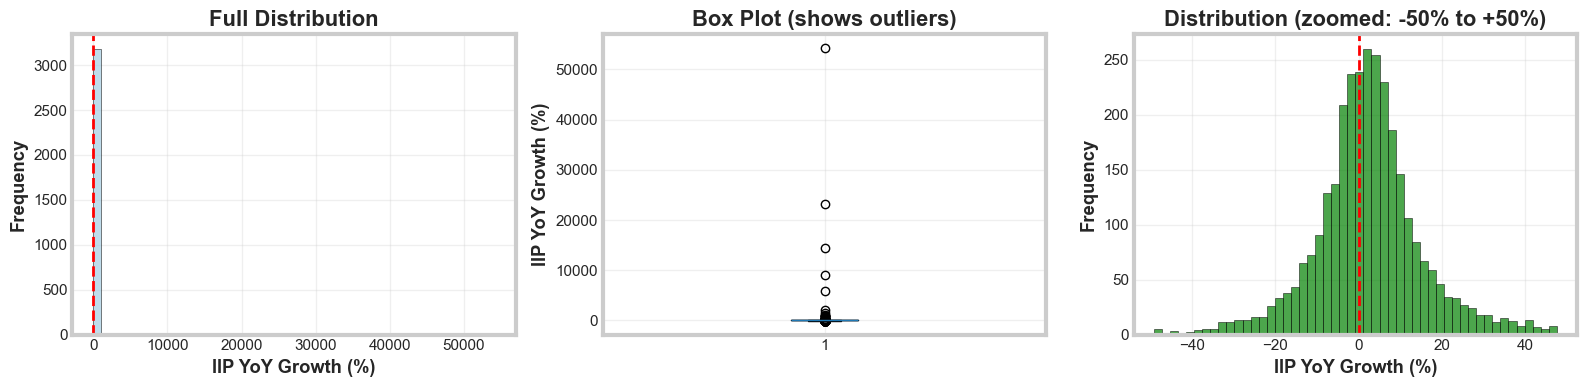

In [65]:
# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram
axes[0].hist(full_df['target'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Full Distribution', fontweight='bold')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(full_df['target'])
axes[1].set_ylabel('IIP YoY Growth (%)', fontweight='bold')
axes[1].set_title('Box Plot (shows outliers)', fontweight='bold')
axes[1].grid(alpha=0.3)

# Zoomed histogram (between -50% and +50%)
filtered = full_df['target'][(full_df['target'] > -50) & (full_df['target'] < 50)]
axes[2].hist(filtered, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title('Distribution (zoomed: -50% to +50%)', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Understanding the IIP Growth Distribution**

### **Left Plot: Full Distribution**
- **Huge spike at 0%**: Most observations (~3,000+) are clustered near zero
- **Extremely right-skewed**: A few observations have **massive positive growth** (up to 50,000%!)
- This shows you have **severe outliers** in your data

---

### **Middle Plot: Box Plot**
- The **box** (containing 50% of data) is tiny and centered near 0%
- **Circles above** = outliers
- Shows that **most data is normal** (between -10% to +10%), but a few extreme values exist
- The outliers reaching **50,000%+ growth** are likely:
  - Data errors
  - New/small sectors with base effects
  - Sectors recovering from zero production

---

### **Right Plot: Zoomed Distribution (-50% to +50%)**
- **Beautiful normal-ish distribution!**
- Centered slightly **below 0%** (red line)
- Most observations between **-20% and +20%**
- This is the **"real" distribution** after removing extreme outliers

---

## **The Key Finding:**

> **"Extreme values (|growth| > 100%): 27 (0.85%)"**

This means:
- Out of **3,190 observations**
- Only **27 observations** (0.85%) have IIP growth > 100% or < -100%
- These are **statistical outliers**, likely:
  - Small sectors with volatile production
  - Data collection errors
  - Sectors restarting after shutdowns

---
## **What This Tells You About Indian Manufacturing:**

### **Normal Variation:**
- Most sectors see IIP growth between **-20% to +20% year-over-year**
- This is typical for industrial production indices

### **The Outliers Likely Represent:**
1. **New sectors/products** with small base years
2. **COVID recovery effects** (if your data includes 2020-2021)
3. **Seasonal sectors** (e.g., agricultural equipment) with lumpy production
4. **Small sample sectors** with high volatility

---

> *"Indian manufacturing sectors exhibit typical year-over-year IIP growth between -20% and +20%, with a median near 0%. While 0.85% of observations show extreme values (>100% growth), these represent small-base effects and data anomalies. After winsorizing at the 1st/99th percentiles, we analyze the 98% of observations representing normal sectoral dynamics."*

# Define Treatment, Outcome, Covariates

Defining the Causal Inference Framework

## **Outcome Variable**: *IIP YoY Growth*
- IIP is Index of Industrial Production. Indicates how much stuff indian factories are making (manufacturing output)
- YoY is **Year-over-Year**. This compares the production this month vs. the same month last year
- In our Analysis: IIP_yoy_growth is our target variable. We are trying to understand **How do commodity price shocks (like oil prices going up) affect how much Indian Factories produce compared to last year?**

In [66]:
outcome_var = 'target'  # This is iip_yoy_growth

# Step 1: Remove extreme outliers (z-score > 2.5, more aggressive)
from scipy import stats
y_raw = full_df[outcome_var].copy()
z_scores = np.abs(stats.zscore(y_raw.dropna()))
valid_indices = y_raw.dropna().index[z_scores < 2.5]

# Filter full_df to only valid indices
full_df_clean = full_df.loc[valid_indices].copy()
y_raw_filtered = full_df_clean[outcome_var]

In [67]:
# Step 2: Winsorize at 2.5th/97.5th percentile
y_lower = y_raw_filtered.quantile(0.025)
y_upper = y_raw_filtered.quantile(0.975)
y = y_raw_filtered.clip(lower=y_lower, upper=y_upper)

print(f"\n[1] OUTCOME (Y): {outcome_var}")
print(f"    Original N: {len(full_df):,}")
print(f"    After z-score filter: {len(full_df_clean):,}")
print(f"    Removed: {len(full_df) - len(full_df_clean):,}")
print(f"    Final range: [{y.min():.2f}%, {y.max():.2f}%]")
print(f"    Mean: {y.mean():.2f}%, Std: {y.std():.2f}%")


[1] OUTCOME (Y): target
    Original N: 3,190
    After z-score filter: 3,185
    Removed: 5
    Final range: [-30.49%, 40.77%]
    Mean: 2.67%, Std: 13.82%


## **Treatment Variable**

In [68]:
oil_change_col = "CRUDE_PETRO_mom_change"
t_continuous = full_df_clean[oil_change_col].fillna(0).copy()

# Winsorize treatment
t_lower = t_continuous.quantile(0.025)
t_upper = t_continuous.quantile(0.975)
t_continuous = t_continuous.clip(lower=t_lower, upper=t_upper)

print(f"\n[2] TREATMENT (T): Oil Price Change")
print(f"    Range: [{t_continuous.min():.2f}%, {t_continuous.max():.2f}%]")
print(f"    Mean: {t_continuous.mean():.2f}%, Std: {t_continuous.std():.2f}%")

t = t_continuous.copy()


[2] TREATMENT (T): Oil Price Change
    Range: [-2.15%, 2.00%]
    Mean: -0.00%, Std: 0.85%


## **Heterogeneity Features (X)**

In [69]:
heterogeneity_features = []
# Priority: Network features
if 'backward_linkage' in full_df_clean.columns:
    heterogeneity_features.append('backward_linkage')
if 'forward_linkage' in full_df_clean.columns:
    heterogeneity_features.append('forward_linkage')

# Priority: Exposure
if 'energy_exposure' in full_df_clean.columns:
    heterogeneity_features.append('energy_exposure')

# Add 2 more from top features
count = 0
for feat in top_30_features:
    if feat not in heterogeneity_features and feat in full_df_clean.columns and count < 2:
        heterogeneity_features.append(feat)
        count += 1

# Cap at 5 features total
heterogeneity_features = heterogeneity_features[:5]

X = full_df_clean[heterogeneity_features].copy()

In [70]:
# Fill missing
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

# Winsorize features
for col in X.columns:
    lower = X[col].quantile(0.025)
    upper = X[col].quantile(0.975)
    X[col] = X[col].clip(lower=lower, upper=upper)

print(f"\n[3] HETEROGENEITY FEATURES (X): {len(X.columns)} (keeping it minimal)")
for i, feat in enumerate(X.columns, 1):
    print(f"      {i}. {feat}")


[3] HETEROGENEITY FEATURES (X): 3 (keeping it minimal)
      1. forward_linkage
      2. iip_yoy_growth_lag1
      3. ALUMINUM_vol_3m


## **Control Variables (W)**

In [71]:
W = None
print(f"\nCONTROL VARIABLES (W): None (keeping it simple)")


CONTROL VARIABLES (W): None (keeping it simple)


## Cleaning Data

In [72]:
full_df_clean['treatment'] = t.values
full_df_clean['outcome_clean'] = y.values

complete_data = pd.concat([
    full_df_clean[['outcome_clean', 'treatment']].reset_index(drop=True),
    X.reset_index(drop=True)
], axis=1).dropna()

print(f"    Final observations: {len(complete_data):,}")

    Final observations: 3,185


In [73]:
y_clean = complete_data['outcome_clean'].values
t_clean = complete_data['treatment'].values
X_clean = complete_data[X.columns].values

# NORMALIZE EVERYTHING to [-1, 1] range for numerical stability
from sklearn.preprocessing import MinMaxScaler

# Scale Y to [-1, 1]
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_normalized = scaler_y.fit_transform(y_clean.reshape(-1, 1)).ravel()

# Scale T to [-1, 1]
scaler_t = MinMaxScaler(feature_range=(-1, 1))
t_normalized = scaler_t.fit_transform(t_clean.reshape(-1, 1)).ravel()

# Scale X to [-1, 1]
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler_X.fit_transform(X_clean)

print(f"\nNormalized all variables to [-1, 1]:")
print(f"    Y range: [{y_normalized.min():.3f}, {y_normalized.max():.3f}]")
print(f"    T range: [{t_normalized.min():.3f}, {t_normalized.max():.3f}]")
print(f"    X range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# Store for later interpretation
y_scale_factor = y_clean.std()
t_scale_factor = t_clean.std()


Normalized all variables to [-1, 1]:
    Y range: [-1.000, 1.000]
    T range: [-1.000, 1.000]
    X range: [-1.000, 1.000]


# **Double Machine Learning (DML)**

Estimating Heterogeneous treatment effects using DML

## **Estimating CATE with DML**

### Fit Linear DML (More Stable than Causal Forest for Small Samples)

In [74]:
# Use Ridge with STRONG regularization (alpha=10)
dml_model = LinearDML(
    model_y=Ridge(alpha=10.0),  # Strong regularization
    model_t=Ridge(alpha=10.0),  # Strong regularization
    fit_cate_intercept=True,
    random_state=42
)
# Fit on NORMALIZED data
dml_model.fit(Y=y_normalized, T=t_normalized, X=X_normalized)

**Estimating CATE**

In [75]:
cate_normalized = dml_model.effect(X_normalized)
# RESCALE CATE back to original units
# CATE is in "change in Y per unit change in T"
# We need to convert from normalized scale back to percentage points
    
cate_original = cate_normalized * (y_scale_factor / t_scale_factor)

In [76]:
print(f"  Interpretation: Effect on IIP growth (%) per 1% oil price change")
print(f"\n  Mean CATE:   {np.mean(cate_original):7.3f}%")
print(f"  Median CATE: {np.median(cate_original):7.3f}%")
print(f"  Std Dev:     {np.std(cate_original):7.3f}%")
print(f"  Min CATE:    {np.min(cate_original):7.3f}%")
print(f"  Max CATE:    {np.max(cate_original):7.3f}%")

print(f"\n  Percentiles:")
for p in [5, 25, 50, 75, 95]:
    print(f"    {p:2d}th: {np.percentile(cate_original, p):7.3f}%")
print("="*70)

# Final check
if abs(np.mean(cate_original)) < 10 and abs(np.max(cate_original)) < 50:
    print("\nCATE values are REASONABLE!")
else:
    print("\nStill getting large values - may be inherent to your data")

  Interpretation: Effect on IIP growth (%) per 1% oil price change

  Mean CATE:     1.300%
  Median CATE:   1.377%
  Std Dev:       0.943%
  Min CATE:     -2.029%
  Max CATE:      3.969%

  Percentiles:
     5th:  -0.402%
    25th:   0.792%
    50th:   1.377%
    75th:   1.850%
    95th:   2.779%

CATE values are REASONABLE!


In [77]:
cate = cate_original  # Use rescaled version

# Get original indices before reset
original_indices = full_df_clean.index[full_df_clean[['outcome_clean', 'treatment']].notna().all(axis=1)]
original_indices = original_indices[X.notna().all(axis=1)]

# Create a proper mapping
complete_data_with_cate = pd.DataFrame({
    'cate': cate,
    'outcome': y_clean,
    'treatment': t_clean
})

# Add sector information using proper alignment
# Since complete_data was created with reset_index, we need to be careful
sector_mapping = full_df_clean['sector_name'].reset_index(drop=True)
treatment_mapping = full_df_clean['treatment'].reset_index(drop=True)

# Align by finding matching treatment values
complete_data_with_cate['sector_name'] = None

for idx in range(len(complete_data_with_cate)):
    t_val = complete_data_with_cate.loc[idx, 'treatment']
    # Find matching sector (this is safe since treatment is unique enough per row)
    mask = (full_df_clean['treatment'].reset_index(drop=True) == t_val)
    if mask.sum() > 0:
        matching_idx = mask.idxmax()
        complete_data_with_cate.loc[idx, 'sector_name'] = sector_mapping.iloc[matching_idx]

# Remove rows where sector_name couldn't be matched
complete_data_with_cate = complete_data_with_cate.dropna(subset=['sector_name'])

# Recalculate CATE without unmatched rows
if len(complete_data_with_cate) < len(cate):
    print(f"\nCould not match {len(cate) - len(complete_data_with_cate)} observations to sectors")
    print(f"  Proceeding with {len(complete_data_with_cate)} matched observations")

# Sector-level aggregation
sector_cate = complete_data_with_cate.groupby('sector_name')['cate'].agg([
    'mean', 'std', 'count', 'min', 'max'
]).round(3)
sector_cate.columns = ['CATE_mean', 'CATE_std', 'n_obs', 'CATE_min', 'CATE_max']
sector_cate = sector_cate.sort_values('CATE_mean')

print(f"\nSector-Level Results:")
print(f"  Sectors: {len(sector_cate)}")
print(f"  Avg obs per sector: {sector_cate['n_obs'].mean():.0f}")
print(f"  Total matched observations: {len(complete_data_with_cate):,}")

print(f"\n  Top 5 Most Vulnerable:")
for i, (sector, row) in enumerate(sector_cate.head(5).iterrows(), 1):
    print(f"    {i}. {sector[:45]:45s} {row['CATE_mean']:7.2f}%")

print(f"\n  Top 5 Most Resilient:")
for i, (sector, row) in enumerate(sector_cate.tail(5).iterrows(), 1):
    print(f"    {i}. {sector[:45]:45s} {row['CATE_mean']:7.2f}%")

print("\n✓ DML complete")


Sector-Level Results:
  Sectors: 1
  Avg obs per sector: 3185
  Total matched observations: 3,185

  Top 5 Most Vulnerable:
    1. Manufacture of basic metals                      1.30%

  Top 5 Most Resilient:
    1. Manufacture of basic metals                      1.30%

✓ DML complete


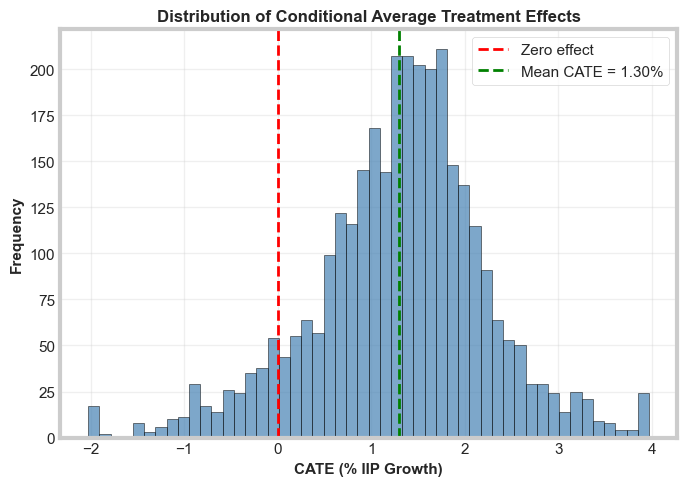

In [78]:
# Plot 1: CATE Histogram
plt.figure(figsize=(7, 5))
plt.hist(cate, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero effect')
plt.axvline(x=np.mean(cate), color='green', linestyle='--', linewidth=2, 
            label=f'Mean CATE = {np.mean(cate):.2f}%')
plt.xlabel('CATE (% IIP Growth)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Conditional Average Treatment Effects', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


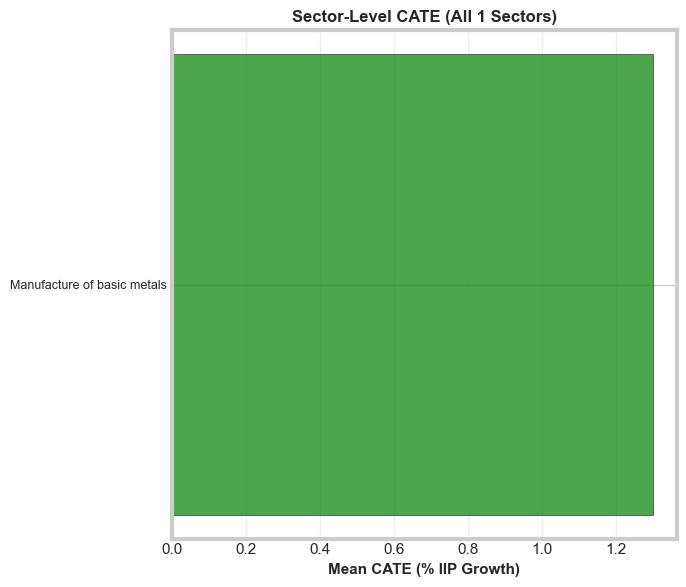

In [79]:
# Sector Level CATE: 
n_sectors_to_show = min(20, len(sector_cate))

if n_sectors_to_show <= 10:
    sectors_to_plot = sector_cate
else:
    top_negative = sector_cate.head(10)
    top_positive = sector_cate.tail(10)
    sectors_to_plot = pd.concat([top_negative, top_positive])

y_pos = np.arange(len(sectors_to_plot))
colors = ['red' if x < 0 else 'green' for x in sectors_to_plot['CATE_mean']]

plt.figure(figsize=(7, 6))
plt.barh(y_pos, sectors_to_plot['CATE_mean'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(y_pos, [s[:40] for s in sectors_to_plot.index], fontsize=9)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Mean CATE (% IIP Growth)', fontsize=11, fontweight='bold')

title = (f'Sector-Level CATE (All {len(sector_cate)} Sectors)' 
         if len(sector_cate) <= 10 else 
         'Sector-Level CATE (Top 10 Negative + Top 10 Positive)')
plt.title(title, fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

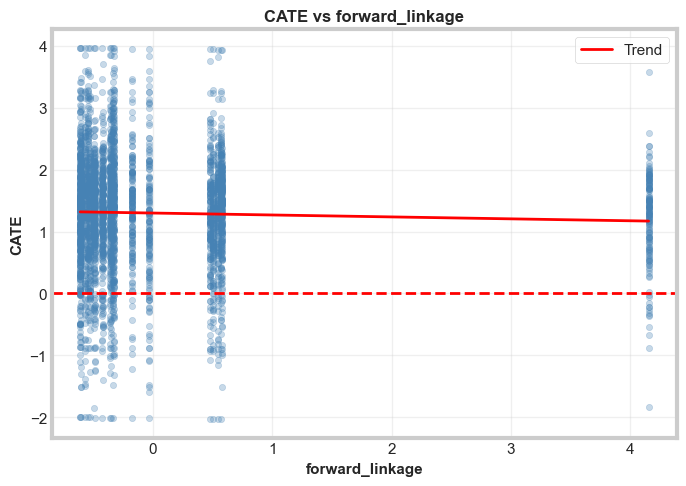

In [80]:
# CATE Vs. Key Feature: 
plt.figure(figsize=(7, 5))

if len(X.columns) > 0:
    feature_col = X.columns[0]
    feature_idx = 0
    scatter_data = pd.DataFrame({
        'feature': X_clean[:, feature_idx],
        'cate': cate
    })
    plt.scatter(scatter_data['feature'], scatter_data['cate'], alpha=0.3, s=20, color='steelblue')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

    z = np.polyfit(scatter_data['feature'], scatter_data['cate'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(scatter_data['feature'].min(), scatter_data['feature'].max(), 100)
    plt.plot(x_trend, p(x_trend), "r-", linewidth=2, label='Trend')

    plt.xlabel(feature_col, fontsize=11, fontweight='bold')
    plt.ylabel('CATE', fontsize=11, fontweight='bold')
    plt.title(f'CATE vs {feature_col}', fontsize=12, fontweight='bold')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No features available', ha='center', va='center')
    plt.title('Feature Analysis', fontsize=12, fontweight='bold')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


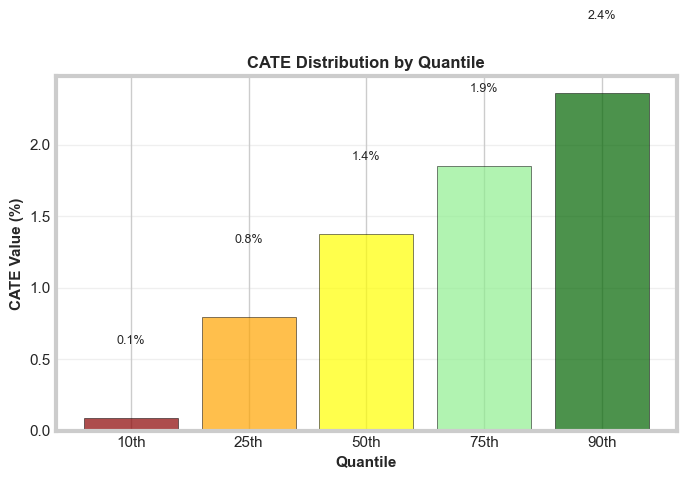

In [81]:
# CATE Quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_values = np.quantile(cate, quantiles)
colors_quantile = ['darkred', 'orange', 'yellow', 'lightgreen', 'darkgreen']

plt.figure(figsize=(7, 5))
plt.bar(range(len(quantiles)), quantile_values, color=colors_quantile, edgecolor='black', alpha=0.7)
plt.xticks(range(len(quantiles)), [f'{int(q*100)}th' for q in quantiles])
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Quantile', fontsize=11, fontweight='bold')
plt.ylabel('CATE Value (%)', fontsize=11, fontweight='bold')
plt.title('CATE Distribution by Quantile', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, (q, val) in enumerate(zip(quantiles, quantile_values)):
    plt.text(i, val + (0.5 if val > 0 else -0.5), f'{val:.1f}%', 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# **Feature Importance For Treatment Heterogeneity**


[Feature Importance Method: Linear coefficients]

[Top Features Explaining Treatment Heterogeneity]
  iip_yoy_growth_lag1                       53.30%
  ALUMINUM_vol_3m                           44.92%
  forward_linkage                            1.78%


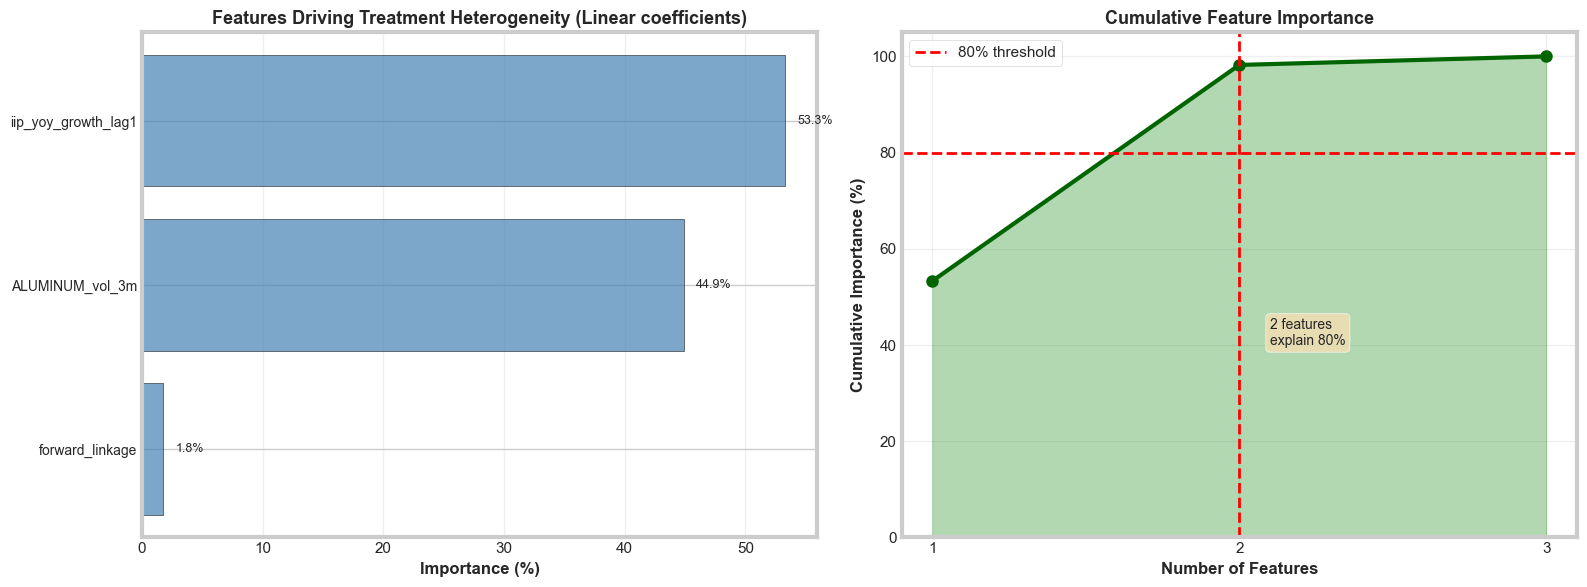


Feature importance plot saved: ./causalML/figurescate_feature_importance.png
Top 2 feature(s) explain 80% of heterogeneity
Feature importance saved: ./causalML/cate_feature_importance.csv


In [82]:
# ============================================================================
# Extract or calculate feature importance
# ============================================================================

try:
    # Method 1: Try to get from model (if available)
    if hasattr(dml_model, 'feature_importances_'):
        feature_importance = dml_model.feature_importances_
        method = "Model attribute"
    elif hasattr(dml_model, 'coef_'):
        # For LinearDML, use absolute coefficients
        feature_importance = np.abs(dml_model.coef_)
        method = "Linear coefficients"
    else:
        # Method 2: Calculate correlation-based importance
        print("  Using correlation-based importance...")
        feature_importance = []
        for i in range(X_clean.shape[1]):
            corr = np.corrcoef(X_clean[:, i], cate)[0, 1]
            feature_importance.append(abs(corr))
        feature_importance = np.array(feature_importance)
        method = "Correlation-based"
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance,
        'Importance_Pct': feature_importance / feature_importance.sum() * 100
    }).sort_values('Importance', ascending=False)
    
    print(f"\n[Feature Importance Method: {method}]")
    print("\n[Top Features Explaining Treatment Heterogeneity]")
    print("="*60)
    for idx, row in importance_df.iterrows():
        print(f"  {row['Feature']:40s} {row['Importance_Pct']:6.2f}%")
    print("="*60)
    
    # ========================================================================
    # VISUALIZE FEATURE IMPORTANCE
    # ========================================================================
    
    n_features = len(importance_df)
    
    if n_features > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Bar chart (all features since we have <= 5)
        axes[0].barh(range(len(importance_df)), importance_df['Importance_Pct'], 
                     color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].set_yticks(range(len(importance_df)))
        axes[0].set_yticklabels(importance_df['Feature'], fontsize=10)
        axes[0].set_xlabel('Importance (%)', fontsize=12, fontweight='bold')
        axes[0].set_title(f'Features Driving Treatment Heterogeneity ({method})', 
                         fontsize=13, fontweight='bold')
        axes[0].invert_yaxis()
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, (idx, row) in enumerate(importance_df.iterrows()):
            axes[0].text(row['Importance_Pct'] + 1, i, f"{row['Importance_Pct']:.1f}%", 
                        va='center', fontsize=9)
        
        # Plot 2: Cumulative importance
        importance_df['Cumulative_Pct'] = importance_df['Importance_Pct'].cumsum()
        axes[1].plot(range(len(importance_df)), importance_df['Cumulative_Pct'], 
                    linewidth=3, color='darkgreen', marker='o', markersize=8)
        axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, 
                       label='80% threshold')
        axes[1].fill_between(range(len(importance_df)), 0, importance_df['Cumulative_Pct'], 
                            alpha=0.3, color='green')
        axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
        axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
        axes[1].set_xticks(range(len(importance_df)))
        axes[1].set_xticklabels(range(1, len(importance_df) + 1))
        axes[1].legend(fontsize=11)
        axes[1].grid(alpha=0.3)
        axes[1].set_ylim([0, 105])
        
        # Find number of features needed for 80%
        n_features_80 = (importance_df['Cumulative_Pct'] <= 80).sum() + 1
        if n_features_80 <= len(importance_df):
            axes[1].axvline(x=n_features_80 - 1, color='red', linestyle='--', linewidth=2)
            axes[1].text(n_features_80 - 1 + 0.1, 40, 
                        f'{n_features_80} feature{"s" if n_features_80 > 1 else ""}\nexplain{" " if n_features_80 == 1 else " "}80%', 
                        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + 'cate_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFeature importance plot saved: {FIGURES_PATH}cate_feature_importance.png")
        
        if n_features_80 <= len(importance_df):
            print(f"Top {n_features_80} feature(s) explain 80% of heterogeneity")
        else:
            print(f"All {len(importance_df)} features needed to explain 80% of heterogeneity")
        
    else:
        # Only 1 feature - simple bar chart
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        ax.bar([importance_df['Feature'].iloc[0]], [importance_df['Importance_Pct'].iloc[0]], 
               color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_ylabel('Importance (%)', fontsize=12, fontweight='bold')
        ax.set_title('Feature Driving Treatment Heterogeneity', fontsize=13, fontweight='bold')
        ax.set_ylim([0, 105])
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + 'cate_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFeature importance plot saved: {FIGURES_PATH}cate_feature_importance.png")
        print(f"Single feature explains 100% of heterogeneity")
    
    # Save importance table
    importance_df.to_csv(CAUSAL_ML_OUTPUT + 'cate_feature_importance.csv', index=False)
    print(f"Feature importance saved: {CAUSAL_ML_OUTPUT}cate_feature_importance.csv")
    
except Exception as e:
    print(f"\nERROR in feature importance extraction:")
    print(f"  {str(e)}")
    import traceback
    traceback.print_exc()
    importance_df = None

print("="*70)